Name: Nathan Hein <br /> 
Semester: Spring 2019 <br /> 
Project Area: Agronomy 

Title: Organizing and Displaying Calculated Results from a HOBO Sensor

This program imports CSV files that have been taken from HOBO Dataloggers and organizes the dataframes to be more intuitive and more easily accessible.  It performs basic calculations to help quanitify the level of heat stress while outputting those results in neatly organized CSV files.  The program also creates multiple graphs to helpe visually represent the data.

In [66]:
# Import Modules
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
import os
%matplotlib inline

In [67]:
# Set variables for data directory, results directory, datafile, start date, end date, and creates a results directory for the file.  

datadirname = '/Users/nhein/Desktop/Coding/Project/Data/'
resultsdirname = '/Users/nhein/Desktop/Coding/Project/Results/'

if os.path.isdir(resultsdirname) == False:
    os.makedirs(resultsdirname)

# data file must be .csv and no periods besides including .csv. The start and end dates must be in YYYY-MM-DD format.
datafile = '2_1HNT_Field.csv'

# For datafile 2_1HNT_Field.csv and Ambient_HNT_Field.csv start date is 2018-06-01 and end date is 2018-06-05.  
# For datafile Ch17-36C.csv and Ch6-28C.csv start date is 2018-12-10 and end date is 2018-12-15
start_date = ['2018-05-25']
end_date = ['2018-05-29']

filename = datafile.split('.')[0]

# Checks if there is a Results folder already created and if not it will create one.
if os.path.isdir(resultsdirname + filename) == False:
    os.makedirs(resultsdirname + filename)

This is how the files look when they are first downloaded form the HOBOs.  With the date and time in the same column it can be time consuming to pull all the data out from specific time intervals or to quickly calculate the hourly averages.  This can become more tediuos because some time the loggers record every 5 minutes and sometimes every 15 depending on the settings. 
![](Misc_Files/CSV_Import.png)


In [68]:
# Import File and delete unneeded columns

df = pd.read_csv(datadirname + datafile, skiprows=1)
df.drop(df.columns[0], axis=1, inplace= True)
df.drop(df.columns[range(3, len(df.columns))], axis=1, inplace = True)
df.columns = ['Full_Date', 'Temp_C', 'RH']

# Change dates to datetime and create new columns with date data needed for calculations
df.Full_Date = pd.to_datetime(df.Full_Date)
df.insert(1,'Date', df.Full_Date.dt.date)
df.insert(2,'Time', df.Full_Date.dt.time)
df.insert(3, 'Hour', df.Full_Date.dt.hour)

# drop rows witn NaNs and resets the index 
df = df.dropna()
df = df.reset_index(drop = True)

In the previous code the dataframe has gone through its first round of organization.  Columns have been renamed and unnecessary columns have been deleted. The date column has been preserved but three new columns have been added to allow for easy sorting of the data which include Date, Time, and Hour.  These columns are all in datetime for future use.  The dataframe still contains all data from the entire period and has not been trimmed down to selected dates.

![](Misc_Files/df_org.png)

In [69]:
# Uses start date and end date to create simple dataframe for reference for trimming down main dataframe    

date_range_df = pd.DataFrame(start_date)
date_range_df.columns = ['Start_Date']
date_range_df.insert(1, 'End_Date', end_date)
date_range_df.Start_Date = pd.to_datetime(date_range_df.Start_Date)
date_range_df.Start_Date = date_range_df.Start_Date.dt.date
date_range_df.End_Date = pd.to_datetime(date_range_df.End_Date)
date_range_df.End_Date = date_range_df.End_Date.dt.date


# Uses date dataframe to trim the top and bottome of the main dataframe to only include selected period
k = 0
start_date_index = []
end_date_index = []
len_date = len(df.Date)

# Finds all the index numbers of the occurences of the Start and End date occuring in the dataframe
for k in range(0, len_date):
    if df.Date[k] == date_range_df.Start_Date[0]:
        start_date_index.append(k) 
    if df.Date[k] == date_range_df.End_Date[0]:
        end_date_index.append(k)
        
# drops all rows with index numbers below the first occurence on the start date and after the last end date occurance and resets the index
df = df.drop(index = range(0, start_date_index[0]))
df = df.drop(index = range(end_date_index[-1] + 1, len_date))
df = df.reset_index(drop = True) 

The previous cell of code creates a new dataframe that includes the user selected Start Date and End Date.  This dataframe only holds those two values for ease of referencing.  The code then creates a list for the start date indexes and the end date indexes.  It runs a loop iterating over the entire file and finds every index in which the start date or end date is present.  It then drops all rows before the first start date index and all the rows after the last end date index, effectively trimming the main data frame to the desired timeframe. 

![](Misc_Files/df_trimmed.png)

In [70]:
# Defining VPD Function
def vpdfun (T_Grid, RH_Grid): 
    '''
    Uses the inputs of Temperature (Celsius) and relative humidity (%RH) and outputs the VPD (kPa).
    Inputs must be in numpy 2D array T in Celsius and RH in %RH with same dimensions.
    Outputs 
    Author: Nathan Hein
    Date: 03/03/2019    
    '''
    esat = .611 * (np.exp((T_Grid * 17.5) / (T_Grid + 241))) # Sat. Vapor Pressure
    eact = esat * (RH_Grid / 100)                            # Actual Vapor Pressure
    vpd = esat - eact                                        # Vapr Pressure Deficit
    vpd = np.round(vpd, 2) 
    return vpd

In [71]:
# Defining Temp and RH variables
T_Grid = df.Temp_C
RH_Grid = df.RH

# Calling function and creating new column in dataframe with VPD if column exists it overwrites the data with the new results.
VPD = vpdfun(T_Grid, RH_Grid)

columncheck = list(df.columns.values)

if 'VPD' in columncheck:
    df.VPD = VPD
else:
    df.insert(6,'VPD', VPD)

# Saves main dataframe to results directory
df.to_csv(resultsdirname + filename + '/' + filename + '-Data.csv')

This cell utilizes the VPD function from the previous cell to calculate the VPD at every instance of data recorded in the selected time frame.  It creates two grids of Temp and RH respectively from the dataframe and calculates the VPD.  The code creates a list of the column names to check if there is a column named VPD and if there is it writes the results in the column and if not it creates a new column and writes the results there.  This was added because if the code is ran more than once and the VPD column existed it would crash the program while trying to create the same column.  The code then saves the dataframe as a CSV.

![](Misc_Files/df_with_vpd.png)

In [72]:
def monthlyhourlyavg (y):
    '''
    Figures the average results of a certain hour of the day between the start and end date. 
    Inputs: When calling function must call with VPD, Temp_C, or RH and will return corresponding results.  
    Author: Nathan Hein
    Date: 04/15/19
    '''
    cols = ['Hour', y]
    rows = []
    xdf = pd.DataFrame(rows, columns=cols)
    resultlist = []
    for x in range(0,24):
        result = df[df['Hour']==x][y]
        resultlist.append(result)
        avg = round(np.mean(resultlist), 3)
        xdf = xdf.append({'Hour': x, y : avg}, ignore_index=True)
        resultlist = []
    return(xdf)

In [73]:
# Call all functions to create dataframes for average VPD Temp and RH for each hour.  Variables in function being called must match the column names in the main
# dataframe that you are trying to use the function on.
MonthlyHourlyVPD = monthlyhourlyavg('VPD')
MonthlyHourlyTemp = monthlyhourlyavg('Temp_C')
MonthlyHourlyRH = monthlyhourlyavg('RH')

# Merges all the resuls data frames into one.
MHA_Merged = pd.merge(pd.merge(MonthlyHourlyTemp, MonthlyHourlyRH, on='Hour'), MonthlyHourlyVPD, on='Hour')

# Saves the results to directory
MHA_Merged.to_csv(resultsdirname + filename + '/' + filename + '-MHA_Merged.csv')

The above code calls the monthlyhourlyavg formula to create dataframes of the VPD, Temp, and RH that include the overall average for each hour of the day for each measurement requeseted.  While calling the function the variable has to match the column name exactly as it is used in the function to go over the data. After creating seperate dataframes the code then merges all them together and saves it as a CSV.

![](Misc_Files/T_RH_VPD_Merged.png)

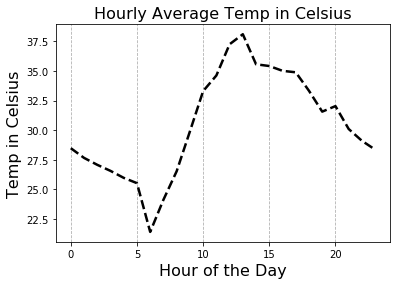

In [74]:
# Create plot with line graph of Hourly Average Temp in Celsius
plt.figure()
plt.rcParams['figure.figsize'] = [8, 5.0]
plt.plot(MHA_Merged.Hour, MHA_Merged.Temp_C, color = 'k', linewidth = 2.5, linestyle = '--')
plt.title('Hourly Average Temp in Celsius', fontsize = 16)
plt.xlabel('Hour of the Day', fontsize = 16)
plt.ylabel('Temp in Celsius', fontsize = 16)
plt.grid(which='major', axis='x', linestyle='--')
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['axes.facecolor'] = 'w'

plt.savefig(resultsdirname + filename + '/' + filename + '-HourlyAVGTemp.jpg', bbox_inches = 'tight')

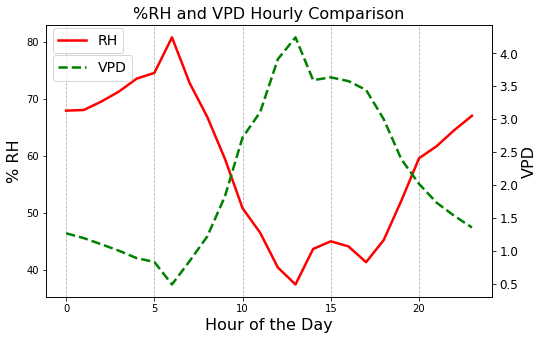

In [75]:
# Creates a plot with both the hourly average %RH and the average VPD. Location of legend can be adjusted by changing bbox_to_anchor.
fig, ax1 = plt.subplots()
plt.rcParams['figure.figsize'] = [8, 5.0]
plt.title('%RH and VPD Hourly Comparison', fontsize = 16)
ax1.grid(which='major', axis='x', linestyle='--')
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['axes.facecolor'] = 'w'
ax1.plot(MHA_Merged.Hour, MHA_Merged.RH, color = 'r', linewidth = 2.5)
plt.legend(loc = 'lower left', bbox_to_anchor = (0,.87), fontsize = 14)

ax2 = ax1.twinx()
ax2.plot(MHA_Merged.Hour, MHA_Merged.VPD, color = 'g', linewidth = 2.5, linestyle = '--')
plt.legend(loc = 'lower left', bbox_to_anchor = (0,.77), fontsize = 14)

ax1.set_xlabel('Hour of the Day', fontsize = 16)
ax1.set_ylabel('% RH', fontsize = 16)
ax2.set_ylabel('VPD', fontsize = 16)

plt.savefig(resultsdirname + filename + '/' + filename + '-RHandVPDCompFig.jpg', bbox_inches = 'tight')

In [76]:
def DailyHourlyAvg (z):
    '''
    Computes the daily hourly average for either RH, VPD, or Temp. 
    Inputs: When calling function must call with VPD, Temp_C, or RH and will return corresponding results.
    Outputs: Dataframe with Hourly average results per day
    Author: Nathan Hein
    Date: 04/15/19
    '''
    days = []
    hours = [range(0,24)]
    deltadays = date_range_df.End_Date[0] - date_range_df.Start_Date[0]
    
    for i in range(0, deltadays.days + 1):
        days.append(date_range_df.Start_Date[0] + timedelta(i))

    HourlyAvgdf = pd.DataFrame(hours)
    HourlyAvgdf = HourlyAvgdf.drop(HourlyAvgdf.index[0])
    HourlyAvgdf.insert(0,'Date','')
    HourlyAvgdf.Date = days

    HAVG = []

    for j in range(0,len(days)):
        for i in range(0,24):
            org = df[(df.Hour == i) & (df.Date == HourlyAvgdf.Date[j])]
            if z == 'VPD':
                HAVG.append(org.VPD)
            if z == 'RH':
                HAVG.append(org.RH)
            if z == 'Temp_C':
                HAVG.append(org.Temp_C)
            x = round(np.mean(HAVG), 3)
            HourlyAvgdf.loc[j, i] = x
            HAVG = []
    return HourlyAvgdf

In [77]:
# Calling Hourly Average function for Temp, RH, and VPD
TempHourlyAvgdf = DailyHourlyAvg('Temp_C')
RHHourlyAvgdf = DailyHourlyAvg('RH')
VPDHourlyAvgdf = DailyHourlyAvg('VPD')

# Saving Resulting data frames as csv
TempHourlyAvgdf.to_csv(resultsdirname + filename + '/' + filename + '-DHATemp.csv',)
RHHourlyAvgdf.to_csv(resultsdirname + filename + '/' + filename + '-DHARH.csv')
VPDHourlyAvgdf.to_csv(resultsdirname + filename + '/' + filename + '-DHAVPD.csv')

This cell calls teh DailyHourlyAvg function with Temp, RH, and VPD creates a dataframe and then saves the dataframe to be used later for graphing.

![](Misc_Files/DailyHourlyAvg.png)

In [78]:
# create new dataframe with previous files results and trim and convert to numpy array
DHATemp1 = TempHourlyAvgdf
DHATemp1 = DHATemp1.drop(columns='Date', axis=1)
nparray1 = DHATemp1.values

#Setting up to import the file you wish to compare to that was created in a previous run of the program
# The files you are comparing must have the same start date and end dates so the arrays are the same size.  If they are different sizes it will not work.
datafile2 = 'Ambient_HNT_Field-DHATemp.csv'
filename2 = datafile2.split('.')[0]
filename2 = filename2.split('-')[0]

# import second DHATemperature File to compare and create numpy array with results
DHATemp2 = pd.read_csv(resultsdirname + filename2 + '/' + datafile2)
DHATemp2 = DHATemp2.drop(columns='Date', axis=1)
DHATemp2 = DHATemp2.drop(columns='Unnamed: 0', axis=1)

nparray2 = DHATemp2.values

# Creates an array to use for the heat map that shows the temperature differential between the two files during the selected period.
heatmaparray = nparray1 - nparray2

# Creates a list of days that were selected at the beginning of the program to label the future heat map
days = []
hours = list(range(0,24))
deltadays = date_range_df.End_Date[0] - date_range_df.Start_Date[0]
for i in range(0, deltadays.days + 1):
    days.append(date_range_df.Start_Date[0] + timedelta(i))

The Daily Hourly Average Temp that was calculated in the previous cells is copied into a new dataframe and its dates are dropped and then is converted into a Numpy Array.  A second file from the ambient sensor that was previously ran in the program up to this point is imported and has the exact same date range as the DHA Temp file we started with. The ambient is then converted to a Numpy array.  The ambient array is subtracted from the field array to create the heatmaparray that shows the temperature differential for every hour of every day of the heat stress. A list of days is also created using the start date and end date at the beginning of the program. 

In [79]:
# Function to create heat map found on official matplotlib documentation. 
# https://matplotlib.org/gallery/images_contours_and_fields/image_annotated_heatmap.html

def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Arguments:
        data       : A 2D numpy array of shape (N,M)
        row_labels : A list or array of length N with the labels
                     for the rows
        col_labels : A list or array of length M with the labels
                     for the columns
    Optional arguments:
        ax         : A matplotlib.axes.Axes instance to which the heatmap
                     is plotted. If not provided, use current axes or
                     create a new one.
        cbar_kw    : A dictionary with arguments to
                     :meth:`matplotlib.Figure.colorbar`.
        cbarlabel  : The label for the colorbar
    All other arguments are directly passed on to the imshow call.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Arguments:
        im         : The AxesImage to be labeled.
    Optional arguments:
        data       : Data used to annotate. If None, the image's data is used.
        valfmt     : The format of the annotations inside the heatmap.
                     This should either use the string format method, e.g.
                     "$ {x:.2f}", or be a :class:`matplotlib.ticker.Formatter`.
        textcolors : A list or array of two color specifications. The first is
                     used for values below a threshold, the second for those
                     above.
        threshold  : Value in data units according to which the colors from
                     textcolors are applied. If None (the default) uses the
                     middle of the colormap as separation.

    Further arguments are passed on to the created text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[im.norm(data[i, j]) > threshold])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

This code was found on matplotlib.org and is official documentation.  I did not write it.

In [ ]:
fig, ax = plt.subplots(figsize = (15,5))

im, cbar = heatmap(heatmaparray, days, hours, ax=ax,
                   cmap="seismic", vmin = 0, vmax = 8, cbarlabel="Temp Diff (Inside - Outside)")

texts = annotate_heatmap(im, data = heatmaparray, valfmt="{x:.1f}")

fig.tight_layout()
plt.savefig(resultsdirname + filename + '/' + filename + '-heatmapcomp.jpg', bbox_inches = 'tight')


This code calls the heatmap functions.  Simply passing the heatmaparray as the values, days as the x axis, hours as the y axis, choosing a colormap, the min and max of the value gradient, and label the color bar.  The texts portion annotates the heat map.  The im passes the im, and data pulls the numbers from the heatmap array.
The figure is then saved.

![](Misc_Files/2_1HNT_Field-heatmapcomp.jpg)

In [ ]:
MHA_Temp_Stress = pd.DataFrame(MHA_Merged.Hour)
MHA_Temp_Stress.insert(1, 'Temp_C', MHA_Merged.Temp_C)
MHA_Temp_Stress = MHA_Temp_Stress.drop(MHA_Temp_Stress.index[7:19])
MHA_Temp_Stress = MHA_Temp_Stress.reindex([19,20,21,22,23,0,1,2,3,4,5,6])
MHA_Temp_Stress['Hour'] = round(MHA_Temp_Stress['Hour'])
MHA_Temp_Stress['Hour'] = MHA_Temp_Stress['Hour'].astype('int32')
MHA_Temp_Stress.Hour = pd.to_datetime(MHA_Temp_Stress.Hour, format = '%H')
MHA_Temp_Stress.insert(1, 'TS_Hour', MHA_Temp_Stress.Hour.dt.hour)


# Create plot with line graph of Hourly Average Temp in Celsius
plt.figure()
plt.rcParams['figure.figsize'] = [8, 5.0]
plt.plot(MHA_Temp_Stress.TS_Hour, MHA_Temp_Stress.Temp_C, color = 'k', linewidth = 2.5, linestyle = '--')
plt.title('Hourly Average Temp in Celsius during Stress', fontsize = 16)
plt.xlabel('Hour of the Day', fontsize = 16)
plt.ylabel('Temp in Celsius', fontsize = 16)
plt.grid(which='major', axis='x', linestyle='--')
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['axes.facecolor'] = 'w'
plt.xticks((19,20,21,22,23,0,1,2,3,4,5,6))

plt.savefig(resultsdirname + filename + '/' + filename + '-HourlyAVGTemp_Stress.jpg', bbox_inches = 'tight')

print(type(MHA_Temp_Stress.TS_Hour[0]))
print(MHA_Temp_Stress)
